In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image

from scipy import ndimage

In [2]:
def plot_estaciones_colombia(data,titulo):
    
    # Cargo el mapa de Colombia
    estaciones_colombia_path = os.path.join('Data Climatica','colombia.geojson')
    mapa = gpd.read_file(estaciones_colombia_path)

    # Selecciono la información de interes para pintar en el mapa
    data_filtrada = data.copy().reset_index()

    # Agrego indices para identificar las estaciones
    for index, row in data_filtrada.iterrows():
        data_filtrada = data_filtrada.copy()
        data_filtrada.loc[index,'NAME'] = '({}) {} - {}°F'.format(index+1,row['NAME'],row['TAVG'])

    colombia_geodf = gpd.GeoDataFrame(
        data_filtrada, geometry=gpd.points_from_xy(data_filtrada.LONGITUDE, data_filtrada.LATITUDE))

    # Construyo la gráfica
    fig, ax = plt.subplots(figsize=(10, 10))

    mapa.plot(column='HECTARES',ax=ax,cmap='Set3')
    colombia_geodf.plot(column='NAME',ax=ax, markersize=50,cmap='gnuplot',legend=True)
    
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1, 0.8, 0.2, 0.2))

    for index, row in colombia_geodf.iterrows():
        x = row['LONGITUDE']
        y = row['LATITUDE']
        plt.text(x, y, index+1, fontsize=12)

    ax.set_title(titulo,pad = 20, 
                 fontdict={'fontsize':20, 'color': '#4873ab'})
    ax.set_xlabel('LONGITUDE')
    ax.set_ylabel('LATITUDE')

In [3]:
def construir_dataframe(colombia_geodf,variable):
    N = len(colombia_geodf)
    dataframe_duplicado = colombia_geodf.copy().reset_index(drop=True) 
    for idx in range(N):
        fila_tmp = colombia_geodf.iloc[idx]
        valor_variable = fila_tmp[variable]
        dataframe_duplicado = dataframe_duplicado.append([fila_tmp]*int(valor_variable),ignore_index=True)
    return dataframe_duplicado

In [4]:
def generar_mapa_calor_variable(dataframe_duplicado,variable=None,nombre_imagen=None,graficar=False):    
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(dataframe_duplicado['geometry'].apply(getx))
    y = list(dataframe_duplicado['geometry'].apply(gety))

    heatmap, xedges, yedges = np.histogram2d(y, x, bins=(50,50))

    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.gaussian_filter(logheatmap, 1.5, mode='nearest')
    
    if graficar:
        plt.subplots(figsize=(8, 8))
        plt.imshow(logheatmap, cmap='jet', extent=extent)
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.show()
    else:
        dataset_climatico_path = os.path.join('Data Climatica',variable)
        if not os.path.exists(dataset_climatico_path):
            os.makedirs(dataset_climatico_path)
        
        plt.subplots(figsize=(8, 8))
        plt.imshow(logheatmap, cmap='jet', extent=extent)
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.savefig(os.path.join(dataset_climatico_path,nombre_imagen), bbox_inches='tight')
        plt.close('all')

In [5]:
data_path = os.path.join('Data Climatica','2189250.csv')
data = pd.read_csv(data_path)

C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data = data.drop(['PRCP_ATTRIBUTES','SNWD','SNWD_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES'], axis=1)

In [7]:
data['DATE'] =  pd.to_datetime(data['DATE'], infer_datetime_format=True)

In [8]:
data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-06,NaN,72.0,NaN,NaN
1,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-08,NaN,69.0,NaN,NaN
2,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-09,NaN,71.0,NaN,NaN
3,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-10,0.04,70.0,NaN,64.0
4,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-11,0.00,69.0,75.0,64.0


In [9]:
data.sort_values(by=['DATE'], inplace=True)

# Visualización de una fecha en particular

In [10]:
data_test = data[data['DATE'] == data['DATE'].max()]

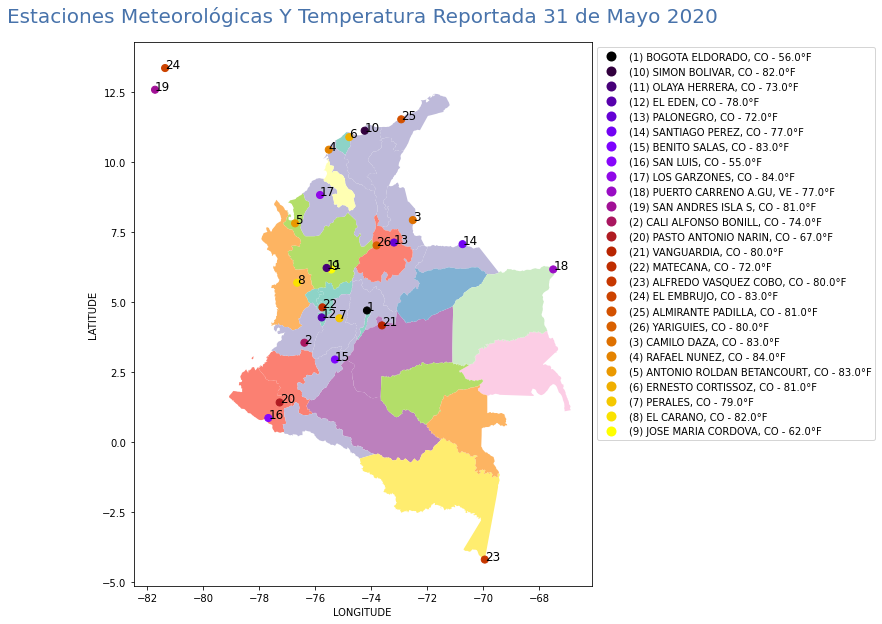

In [11]:
plot_estaciones_colombia(data_test,'Estaciones Meteorológicas Y Temperatura Reportada 31 de Mayo 2020')

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)


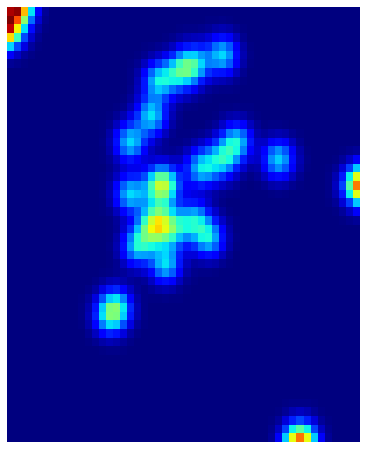

In [12]:
dataframe_points = gpd.points_from_xy(data_test['LONGITUDE'], data_test['LATITUDE'])
colombia_geodf = gpd.GeoDataFrame(data_test,geometry=dataframe_points)

dataframe_duplicado = construir_dataframe(colombia_geodf,'TAVG')
generar_mapa_calor_variable(dataframe_duplicado,graficar=True)

# Construcción del Conjunto de Datos

In [13]:
fechas_unicas = pd.unique(data['DATE'])

In [14]:
for variable in ['TAVG','PRCP']:
    for fecha in fechas_unicas:
        dataframe_por_fecha = data[data['DATE'] == fecha]

        dataframe_points = gpd.points_from_xy(dataframe_por_fecha['LONGITUDE'], dataframe_por_fecha['LATITUDE'])
        colombia_geodf = gpd.GeoDataFrame(dataframe_por_fecha,geometry=dataframe_points)

        colombia_geodf[variable] = colombia_geodf[variable].fillna(0)
        if variable == 'PRCP':
            colombia_geodf[variable] = colombia_geodf[variable]*100

        dataframe_duplicado = construir_dataframe(colombia_geodf,variable)

        nombre_imagen = str(fecha).split('T')[0]
        generar_mapa_calor_variable(dataframe_duplicado,variable,'{}.jpg'.format(nombre_imagen))

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun

<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
<ipython-input-4-e938d3fe190d>:15: RuntimeWarning: divide by zero encoun